## abstract
- goal of this notebook is to test different implementations of parallel processing in python

In [1]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import os
import psutil
cc = psutil.cpu_count(logical = False)
print(f"{cc} CPU cores detected")

def square(x):
    return x**2

repeats = 3
tmax = 10  # seconds
start_n = 12

12 CPU cores detected


## multiprocessing.Pool

In [2]:
%%writefile _ext_func.py
# there is a parallel multiprocessing problem on windows (https://bobswinkels.com/posts/multiprocessing-python-windows-jupyter/) which requires this workaround
def square(x, e=2):
    return x**e

Writing _ext_func.py


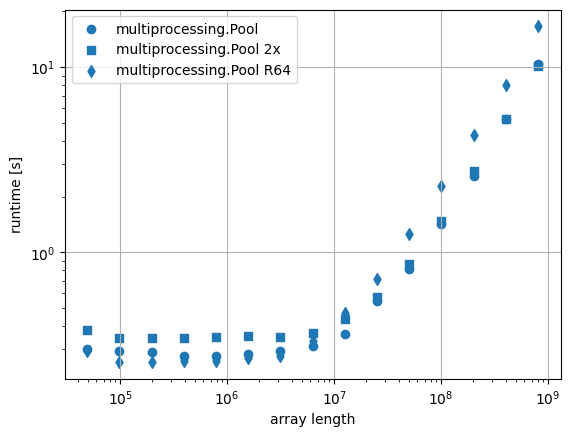

In [3]:
from multiprocessing import Pool
from ext_func import square as ext_square # there is a parallel multiprocessing problem on windows (https://bobswinkels.com/posts/multiprocessing-python-windows-jupyter/) which requires this workaround

t = 0
n = start_n
fig, ax = plt.subplots()
plt.grid()
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        # with Pool() as pool: print(pool.map(square, numbers))  would work on Linux, but causes AttributeError on windows
        with Pool(cc) as pool: pool.map(ext_square, numbers.reshape(cc, -1))
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, color = "tab:blue", label = "multiprocessing.Pool")
    else:      ax.scatter(len(numbers), t, color = "tab:blue")
    n += 1
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("array length")
ax.set_ylabel("runtime [s]")

t = 0
n = start_n
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        # with Pool() as pool: print(pool.map(square, numbers))  would work on Linux, but causes AttributeError on windows
        with Pool(cc*2) as pool: pool.map(ext_square, numbers.reshape(cc, -1))
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, marker = "s", color = "tab:blue", label = "multiprocessing.Pool 2x")
    else:      ax.scatter(len(numbers), t, marker = "s", color = "tab:blue")
    n += 1


t = 0
n = start_n
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        # with Pool() as pool: print(pool.map(square, numbers))  would work on Linux, but causes AttributeError on windows
        with Pool(cc) as pool: pool.map(ext_square, numbers.reshape(cc*64, -1))
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, marker = "d", color = "tab:blue", label = "multiprocessing.Pool R64")
    else:      ax.scatter(len(numbers), t, marker = "d", color = "tab:blue")
    n += 1
clear_output()

ax.legend()
plt.show()

## joblib

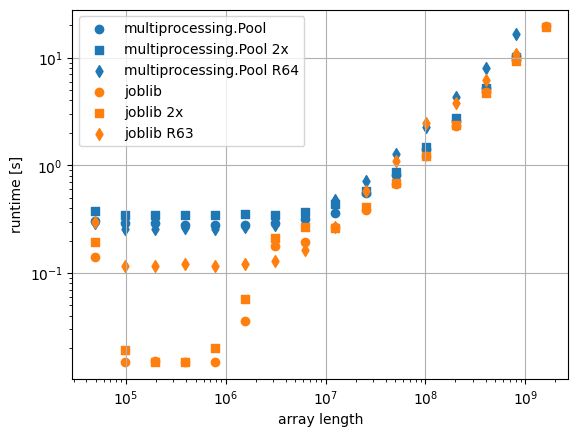

In [4]:
from joblib import Parallel, delayed

t = 0
n = start_n
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        Parallel(n_jobs=cc)(delayed(square)(i) for i in numbers.reshape(cc, -1))
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, color = "tab:orange", label = "joblib")
    else:      ax.scatter(len(numbers), t, color = "tab:orange")
    n += 1

t = 0
n = start_n
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        Parallel(n_jobs=cc*2)(delayed(square)(i) for i in numbers.reshape(cc, -1))
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, marker = "s", color = "tab:orange", label = "joblib 2x")
    else:      ax.scatter(len(numbers), t, marker = "s", color = "tab:orange")
    n += 1

t = 0
n = start_n
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        Parallel(n_jobs=cc)(delayed(square)(i) for i in numbers.reshape(cc*64, -1))
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, marker = "d", color = "tab:orange", label = "joblib R63")
    else:      ax.scatter(len(numbers), t, marker = "d", color = "tab:orange")
    n += 1
clear_output()
ax.legend()
fig

## dask

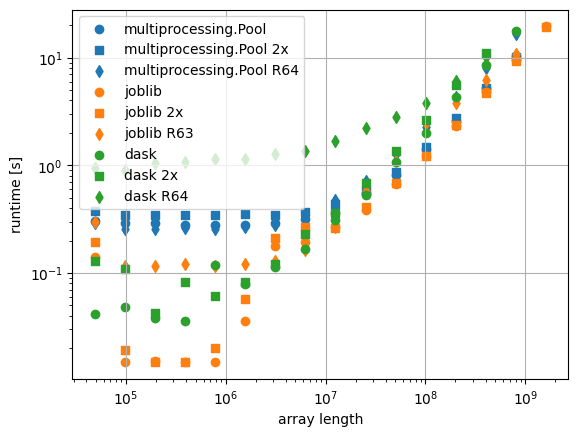

In [5]:
import dask
from dask.distributed import client
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Sending large graph of size")
# Note: this is not the ideal use case of dask, as its strength is lazy dataloading which is not used here.

local_cluster = client.Client(n_workers = cc)

t = 0
n = start_n
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        queue = [dask.delayed(square)(i) for i in numbers.reshape(cc, -1)]
        dask.compute(queue)
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, color = "tab:green", label = "dask")
    else:      ax.scatter(len(numbers), t, color = "tab:green")
    n += 1

local_cluster.close()
local_cluster = client.Client(n_workers = cc*2)

t = 0
n = start_n
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        queue = [dask.delayed(square)(i) for i in numbers.reshape(cc, -1)]
        dask.compute(queue)
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, marker = "s",  color = "tab:green", label = "dask 2x")
    else:      ax.scatter(len(numbers), t, marker = "s",  color = "tab:green")
    n += 1


local_cluster.close()
local_cluster = client.Client(n_workers = cc)

t = 0
n = start_n
while t < tmax:
    numbers = np.arange(cc*2**n)
    s = time()
    for _ in range(repeats):
        queue = [dask.delayed(square)(i) for i in numbers.reshape(cc*64, -1)]
        dask.compute(queue)
    t = (time()-s) / repeats
    print(f"{t:.3g}s", n)
    if n == start_n: ax.scatter(len(numbers), t, marker = "d",  color = "tab:green", label = "dask R64")
    else:      ax.scatter(len(numbers), t, marker = "d",  color = "tab:green")
    n += 1
clear_output()

ax.legend()
fig

Conclusion: for this task it seems joblib and multiprocessing are similar at the high end, but joblib is better at the low end, while dask is generally slower than joblib. But then this is not the ideal usecase for dask. Whether joblib and multiprocessing is faster for sequence search has to be determined with the respective code and data volume. 

In [6]:
os.remove("_ext_func.py")